In [1]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("datasnaek/youtube-new")
print("Path to dataset files:", path)

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print("Найдены файлы:", csv_files)

dfs = []
for file in csv_files:
    full_path = os.path.join(path, file)
    try:
        df_temp = pd.read_csv(full_path, encoding='utf-8', on_bad_lines='skip', low_memory=False)
    except UnicodeDecodeError:
        try:
            df_temp = pd.read_csv(full_path, encoding='latin1', on_bad_lines='skip', low_memory=False)
        except Exception as e:
            print(f"Не удалось прочитать файл {file}: {e}")
            continue
    dfs.append(df_temp)
    print(f"Загружен файл: {file}, строк: {len(df_temp)}")

df = pd.concat(dfs, ignore_index=True)
print("\nОбщий размер датасета:", df.shape)

Using Colab cache for faster access to the 'youtube-new' dataset.
Path to dataset files: /kaggle/input/youtube-new
Найдены файлы: ['GBvideos.csv', 'MXvideos.csv', 'KRvideos.csv', 'DEvideos.csv', 'FRvideos.csv', 'USvideos.csv', 'INvideos.csv', 'RUvideos.csv', 'JPvideos.csv', 'CAvideos.csv']
Загружен файл: GBvideos.csv, строк: 38916
Загружен файл: MXvideos.csv, строк: 40451
Загружен файл: KRvideos.csv, строк: 34567
Загружен файл: DEvideos.csv, строк: 40840
Загружен файл: FRvideos.csv, строк: 40724
Загружен файл: USvideos.csv, строк: 40949
Загружен файл: INvideos.csv, строк: 37352
Загружен файл: RUvideos.csv, строк: 40739
Загружен файл: JPvideos.csv, строк: 20523
Загружен файл: CAvideos.csv, строк: 40881

Общий размер датасета: (375942, 16)


In [ ]:
usecols = ['category_id', 'views', 'likes', 'dislikes', 'comment_count']

for file in csv_files:
    full_path = os.path.join(path, file)
    try:
        df_temp = pd.read_csv(
            full_path,
            usecols=usecols,
            encoding='utf-8',
            on_bad_lines='skip',
            low_memory=False
        )
    except (UnicodeDecodeError, ValueError):
        try:
            df_temp = pd.read_csv(
                full_path,
                usecols=usecols,
                encoding='latin1',
                on_bad_lines='skip',
                low_memory=False
            )
        except Exception as e:
            print(f"Пропущен файл {file}: {e}")
            continue
    dfs.append(df_temp)

In [ ]:
print(df[['views', 'likes', 'dislikes', 'comment_count']].head())
print(df['category_id'].value_counts().head())

      views   likes  dislikes  comment_count
0   7224515   55681     10247           9479
1   1053632   25561      2294           2757
2  17158579  787420     43420         125882
3     27833     193        12             37
4      9815      30         2             30
category_id
24    109006
22     54052
10     42514
25     37288
23     26970
Name: count, dtype: int64


In [ ]:
df['views'] = df['views'].astype(str).str.replace(',', '').astype(float)

In [ ]:
print("Столбцы датасета:")
print(df.columns.tolist())
print("\nПервые 3 строки:")
print(df.head(3))

print("\nИнформация о датафрейме:")
print(df.info())

if 'country' not in df.columns:
    pass

numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']

for col in numeric_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df[
    (df['views'] > 0) &
    (df['likes'] >= 0) &
    (df['dislikes'] >= 0) &
    (df['comment_count'] >= 0)
].copy()

df['category_id'] = pd.to_numeric(df['category_id'], errors='coerce')
df = df.dropna(subset=['views', 'likes', 'category_id'])

df = df.reset_index(drop=True)

print(f"\n✅ После очистки осталось: {len(df)} видео")
print(f"\nДиапазон просмотров: от {df['views'].min():,} до {df['views'].max():,}")
print(f"Среднее количество просмотров: {df['views'].mean():,.0f}")

Столбцы датасета:


NameError: name 'df' is not defined

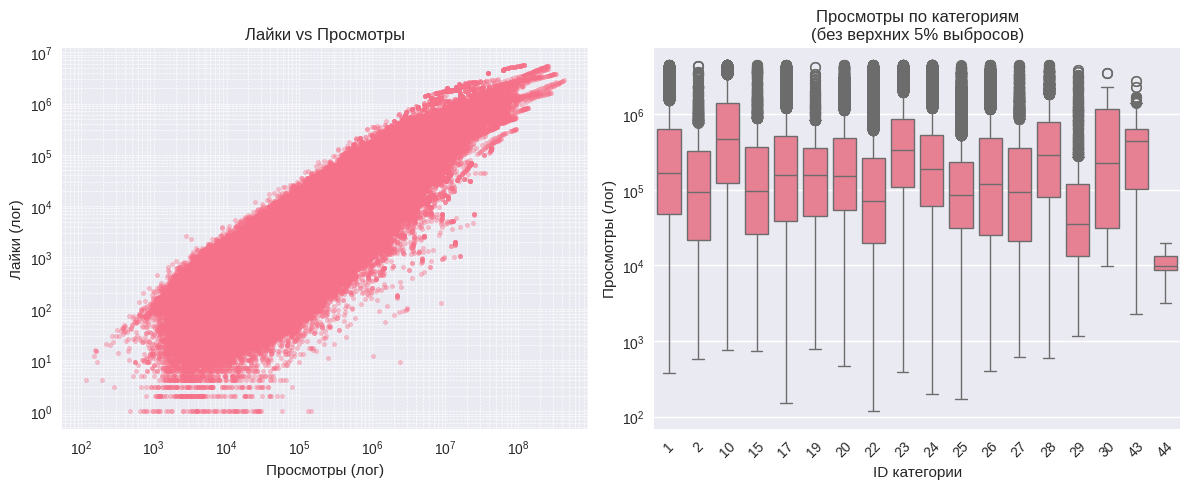

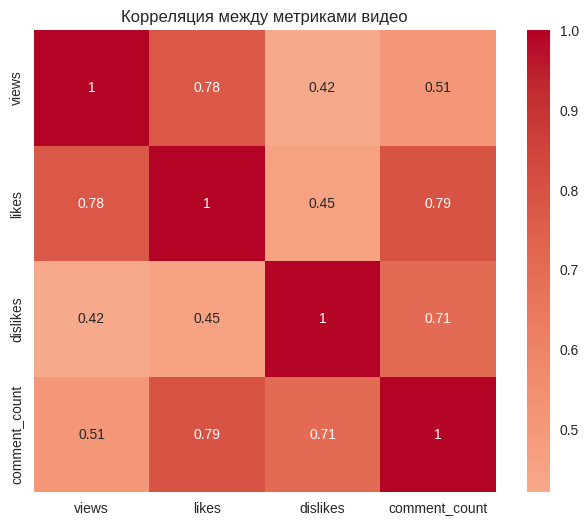


ТОП-5 категорий по количеству видео:
category_id
24    109006
22     54052
10     42514
25     37288
23     26970
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['views'], df['likes'], alpha=0.4, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Просмотры (лог)')
plt.ylabel('Лайки (лог)')
plt.title('Лайки vs Просмотры')
plt.grid(True, which="both", ls="--", linewidth=0.5)

views_95 = df['views'].quantile(0.95)
df_filtered = df[df['views'] <= views_95]

plt.subplot(1, 2, 2)
sns.boxplot(data=df_filtered, x='category_id', y='views')
plt.yscale('log')
plt.xlabel('ID категории')
plt.ylabel('Просмотры (лог)')
plt.title('Просмотры по категориям\n(без верхних 5% выбросов)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
corr_cols = ['views', 'likes', 'dislikes', 'comment_count']
corr = df[corr_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Корреляция между метриками видео')
plt.show()

print("\nТОП-5 категорий по количеству видео:")
print(df['category_id'].value_counts().head())

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df['log_views'] = np.log1p(df['views'])

feature_cols = ['likes', 'dislikes', 'comment_count', 'category_id']

X = df[feature_cols].copy()
y = df['log_views'].copy()

X = X.dropna()
y = y.loc[X.index]

print(f"✅ Форма признаков X: {X.shape}")
print(f"✅ Форма целевой переменной y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Данные готовы к обучению!")
print(f"Train size: {X_train_scaled.shape[0]}")
print(f"Test size:  {X_test_scaled.shape[0]}")

✅ Форма признаков X: (375942, 4)
✅ Форма целевой переменной y: (375942,)

✅ Данные готовы к обучению!
Train size: 300753
Test size:  75189


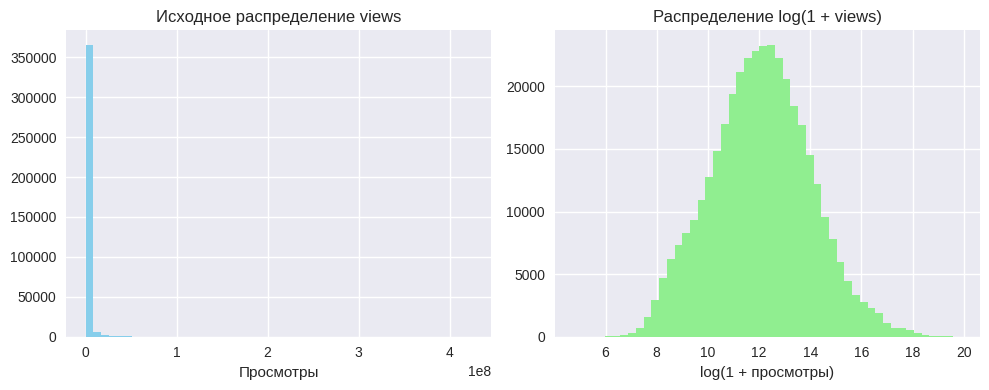

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df['views'], bins=50, color='skyblue')
plt.title('Исходное распределение views')
plt.xlabel('Просмотры')

plt.subplot(1, 2, 2)
plt.hist(df['log_views'], bins=50, color='lightgreen')
plt.title('Распределение log(1 + views)')
plt.xlabel('log(1 + просмотры)')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 33.9228 - mae: 3.9033 - val_loss: 1.5410 - val_mae: 0.9769
Epoch 2/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.9517 - mae: 1.3353 - val_loss: 1.1120 - val_mae: 0.8227
Epoch 3/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.1686 - mae: 1.1523 - val_loss: 1.0488 - val_mae: 0.8065
Epoch 4/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.8514 - mae: 1.0683 - val_loss: 0.9621 - val_mae: 0.7687
Epoch 5/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.6002 - mae: 0.9966 - val_loss: 0.8959 - val_mae: 0.7414
Epoch 6/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.3449 - mae: 0.9109 - val_loss: 0.9467 - val_mae: 0.7656
Epoch 7/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.1322 - mae: 0.8358 - val_loss: 0.9098 - val_mae: 0.7434
Epoch 8/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0091 - mae: 0.7909 - val_loss: 0.8095 - val_mae: 0.6998
Epoch 9/20
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - l

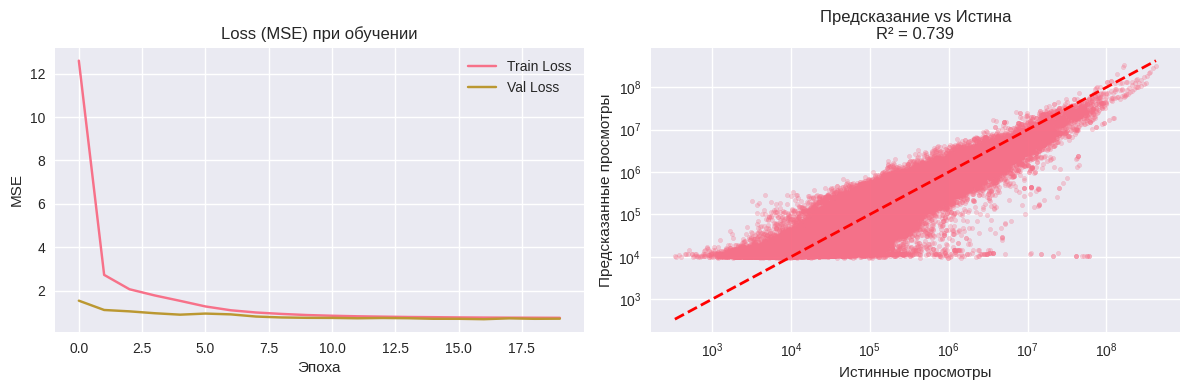

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

y_pred = model.predict(X_test_scaled).flatten()

y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

r2 = r2_score(y_test_original, y_pred_original)
print(f"\n R² на тестовом наборе (в исходных просмотрах): {r2:.4f}")

if r2 >= 0.6:
    print("Цель достигнута: R² ≥ 0.6!")
else:
    print("Цель не достигнута. Нужно улучшать модель.")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE) при обучении')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test_original, y_pred_original, alpha=0.3, s=10)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Истинные просмотры')
plt.ylabel('Предсказанные просмотры')
plt.title(f'Предсказание vs Истина\nR² = {r2:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

📊 Факторы, влияющие на количество просмотров:
1. dislikes: 0.733
2. likes: 0.221
3. comment_count: 0.026
4. category_id: 0.020


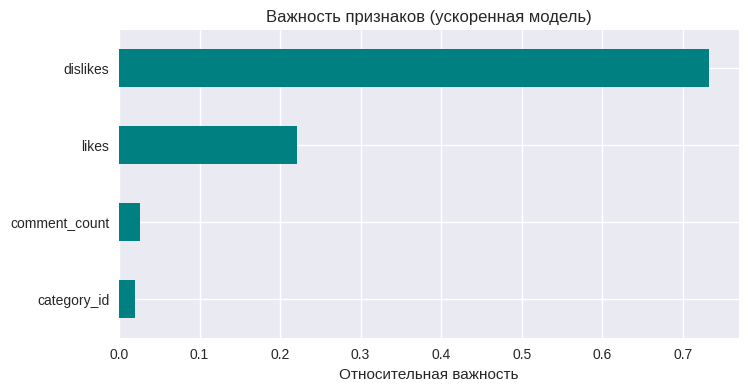

In [ ]:
n_samples = min(10000, len(X_clean))
idx = X_clean.sample(n=n_samples, random_state=42).index

X_sample = X_clean.loc[idx]
y_sample = y_clean.loc[idx]

rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_sample, y_sample)

importances = pd.Series(rf_model.feature_importances_, index=feature_cols)
importances_sorted = importances.sort_values(ascending=False)

print("📊 Факторы, влияющие на количество просмотров:")
for i, (feature, imp) in enumerate(importances_sorted.items(), 1):
    print(f"{i}. {feature}: {imp:.3f}")

importances_sorted.plot(kind='barh', figsize=(8, 4), color='teal')
plt.title('Важность признаков (ускоренная модель)')
plt.xlabel('Относительная важность')
plt.gca().invert_yaxis()
plt.show()